In [1]:
import tellurium as te

In [43]:
# model from https://www.sciencedirect.com/science/article/pii/S0022519300921507
# time step is in days? G and I are in days at least.

r = te.loada("""
species $G; species $I; species $beta;

G' = R0 - (EG0 + SI*I)*G; // glucose concentration in blood (mg/dL)
I' = beta*sigma*G^2/(alpha + G^2) - k*I; // insulin concentration in blood
beta' = (-d0 + r1*G - r2*G^2)*beta; // beta cell mass

// parameters
SI = 0.72;
EG0 = 1.44;
R0 = 864;
sigma = 43.2;
alpha = 20000;
k = 432;
d0 = 0.06;
r1 = 0.84*10^(-3);
r2 = 0.24*10^(-5);

//initial values
beta = 300;
G = 100;
I = 0;

G is "blood glucose concentration (mg/dL)";
I is "blood insulin concentration (microU/mL)";
beta is "beta cell mass";
""")

In [44]:
from tellurium import SBMLDiagram
diagram = SBMLDiagram(r.getSBML())

In [45]:
diagram.g.nodes()

['G', 'I', 'beta']

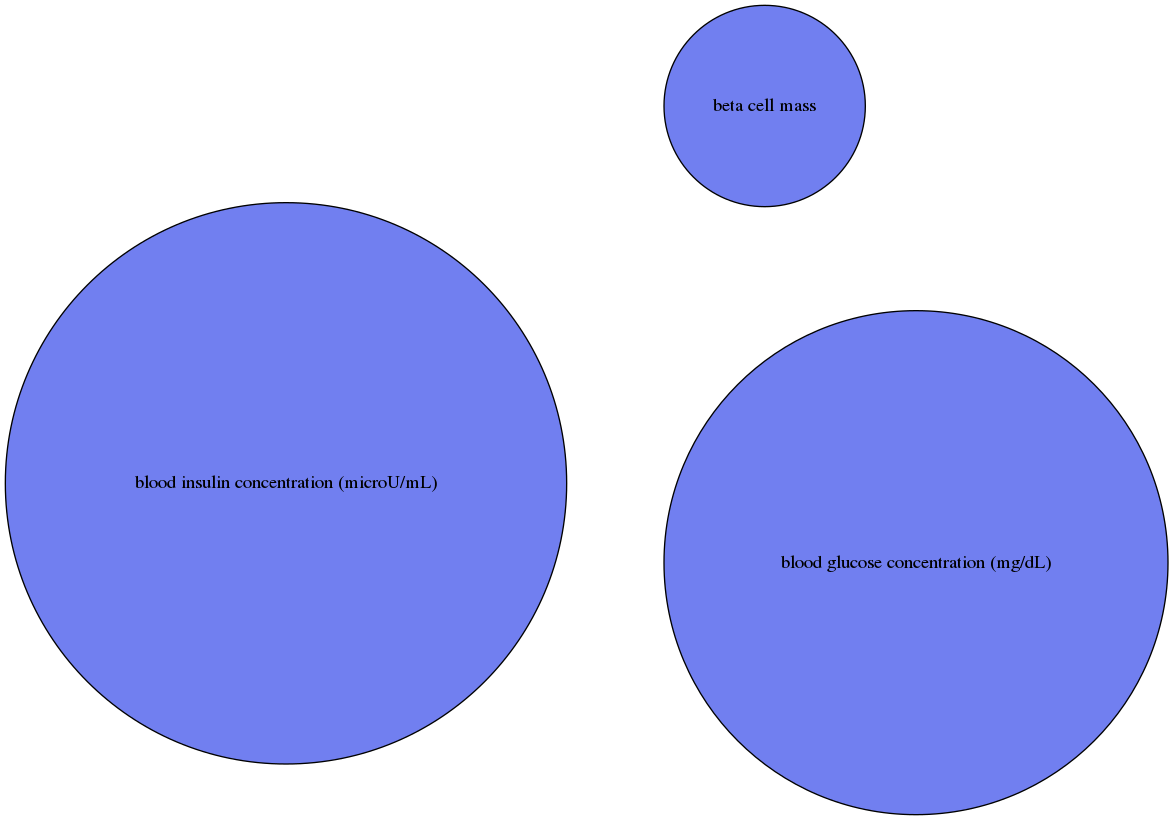

In [46]:
diagram.draw()

In [4]:
result = r.simulate(0, 80)

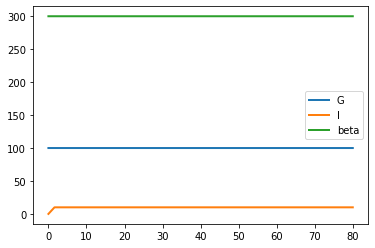

In [6]:
# physiological steady state: beta = 300, G = 100, I = 10
r.plot(result)

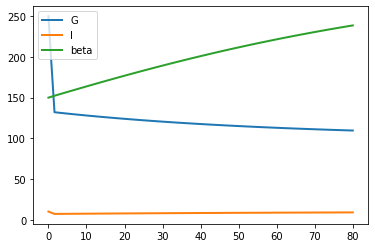

In [10]:
# Try some different values: G = 150?
r.setValue('G', 250)
r.setValue('beta', 150)
result = r.simulate(0, 80)
r.plot(result)

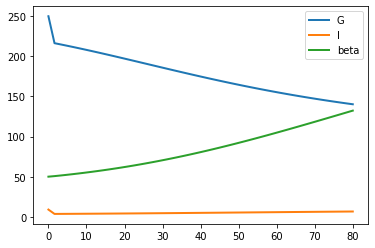

In [11]:
# Try some different values: G = 150?
r.setValue('G', 250)
r.setValue('beta', 50)
result = r.simulate(0, 80)
r.plot(result)

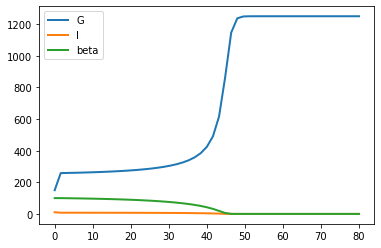

In [20]:
# Converging to pathological state - increasing daily net glucose production
r.setValue('G', 150)
r.setValue('beta', 100)
r.setValue('R0', 1800)
result = r.simulate(0, 80)
r.plot(result)

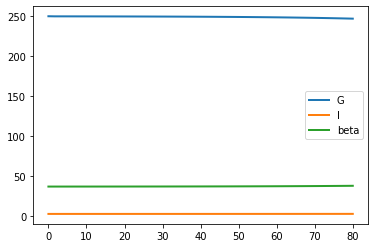

In [23]:
# saddle point
r.resetAll()
r.setValue('G', 250)
r.setValue('beta', 37)
r.setValue('I', 2.8)
result = r.simulate(0, 80)
r.plot(result)